In [1]:
import sys
from platform import uname
import os
import nest_asyncio
nest_asyncio.apply()

import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import datetime
#np.random.seed(0)
from time import time
from matplotlib import pyplot as plt

PREFIX_DIR='./'

%load_ext tensorboard
t1=time()

In [2]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [3]:
dataset_user_0 = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])


In [4]:
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10
BATCH_SIZE = 20
NUM_EPOCHS = 5
use_cnn =False
def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 28*28]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

preprocessed_example_dataset = preprocess(dataset_user_0)

def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

def give_sample_cilents(count):
    return np.random.choice(emnist_train.client_ids,count)
    

In [5]:
def create_keras_model():
  return tf.keras.models.Sequential([
      
      tf.keras.layers.Input(shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])



def create_keras_model_cnn():
  return tf.keras.models.Sequential([
      tf.keras.layers.Reshape((28,28,1), input_shape=(784,)),
      tf.keras.layers.Conv2D(28, (3,3), activation='relu', input_shape=(28,28,1)),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax'),
  ])
      
    
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  if use_cnn:
    keras_model = create_keras_model_cnn()
  else:
    keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])



In [6]:
def run_sim_fed(NUM_CLIENTS, NUM_ROUNDS, sample_every_iteration):
    sample_clients = give_sample_cilents(NUM_CLIENTS)

    federated_train_data = make_federated_data(emnist_train, sample_clients)


    iterative_process = tff.learning.build_federated_averaging_process(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))


    if (uname())[0]!='Windows':
        print(1)
        logdir = "/tmp/logs/scalars/training/"
        !del {logdir}
    else:
        logdir = "D:/logs/scalars/training/"
        logdir = logdir.replace('/','\\')
        !del /Q "D:\logs\scalars\training\*"
    summary_writer = tf.summary.create_file_writer(logdir)
    state = iterative_process.initialize()


    evaluation = tff.learning.build_federated_evaluation(model_fn)
    fed_train_results=[]
    fed_test_results=[]
    with summary_writer.as_default():
      for round_num in range(1, NUM_ROUNDS):
        if sample_every_iteration:
            sample_clients = give_sample_cilents(NUM_CLIENTS)
        federated_train_data = make_federated_data(emnist_train, sample_clients)
        state, metrics = iterative_process.next(state, federated_train_data)

        # Testing
        sample_clients = give_sample_cilents(NUM_CLIENTS) # we sample again with the same number of users but not necessarily same users
        federated_test_data = make_federated_data(emnist_test, sample_clients)
        test_metrics_federated = evaluation(state.model, federated_test_data)
        fed_test_results.append(test_metrics_federated)
        fed_train_results.append(metrics)
        for name, value in metrics['train'].items():
          tf.summary.scalar(name, value, step=round_num)
        print('round {}/{} Loss={:.4} Accuracy={:.4}'.format(round_num+1, NUM_ROUNDS,metrics['train']['loss'],metrics['train']['sparse_categorical_accuracy']))
    

    return (fed_train_results,fed_test_results)

In [7]:
def save_plot(val1,label1,val2,label2, x_label ,y_label,  fig_name):
    plt.plot(val1, label=label1)
    plt.plot(val2, label=label2)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend()
    plt.savefig(fig_name)
    plt.close()
    

In [10]:
def preprocess_no_repeat(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 28*28]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

def make_federated_data_no_repeat(client_data, client_ids):
  return [
      preprocess_no_repeat(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]


In [11]:
NUM_CLIENTS = 20
NUM_ROUNDS = 50
sample_every_iteration = True

(fed_train_results,fed_test_results) = run_sim_fed(NUM_CLIENTS, NUM_ROUNDS , sample_every_iteration)

federated_accuracy_train = [ tr['train']['sparse_categorical_accuracy'] for tr in fed_train_results]
federated_loss_train = [ tr['train']['loss'] for tr in fed_train_results]
federated_accuracy_test = [ tr['sparse_categorical_accuracy'] for tr in fed_test_results]
federated_loss_test = [ tr['loss'] for tr in fed_test_results]

federated_loss_train.append(federated_loss_train[-1])  # to be same size as test

NameError: name 'create_keras_model_cnn' is not defined

In [21]:
if use_cnn:
    fig_name = PREFIX_DIR + 'fed\\cnn_' + str(NUM_CLIENTS) + "_" + str(NUM_ROUNDS)
else:
    fig_name = PREFIX_DIR + 'fed\\nn_' + str(NUM_CLIENTS) + "_" + str(NUM_ROUNDS)

fig_name_acc  = fig_name + "_acc.png"
save_plot(federated_accuracy_train,"train dataset",federated_accuracy_test,"test dataset", "Round" ,"Accuracy",  fig_name_acc)

fig_name_loss  = fig_name + "_loss.png"
save_plot(federated_loss_train,"train dataset",federated_loss_test,"test dataset", "Round" ,"Loss",  fig_name_loss)



In [22]:
use_cnn

False

In [31]:

#%tensorboard --logdir {logdir} --port=0

# Comparison to equivalent centralized model

In [32]:
full_federated_train_data = make_federated_data_no_repeat(emnist_train, give_sample_cilents(NUM_CLIENTS))
full_federated_test_data = make_federated_data_no_repeat(emnist_test, give_sample_cilents(NUM_CLIENTS))

try:
    del train_images, train_labels
except:
    pass
i=1
f=0
for cl_data in full_federated_train_data:
    
    for data in cl_data:
        try:
          train_labels = np.append(train_labels, data['y'], axis=0)
          train_images = np.append(train_images, data['x'], axis=0)

        except:
          train_labels = np.array(data['y'])
          train_images = np.array(data['x'])

    if i%10==0:
        print("{}/{}".format(i,len(full_federated_train_data)))
    i=i+1
 
# test data
f=1
i=1
try:
    del test_labels, test_images
except:
    pass

for cl_data in full_federated_test_data:
  for data in cl_data:
    if(f):
      test_labels = np.array(data['y'])
      test_images = np.array(data['x'])
      f=0
    else:  
      test_labels= np.append(test_labels, data['y'].numpy(), axis=0)
      test_images= np.append(test_images, data['x'].numpy(), axis=0)
   
  if(i%10==0):
    print("{}/{}".format(i,len(full_federated_test_data)))
  i=i+1

centralized_model = create_keras_model()

centralized_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

#!rm -rf ./logs/
log_dir2 = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)


10/20
20/20
10/20
20/20


In [33]:
res=centralized_model.fit(train_images, train_labels, epochs=(NUM_ROUNDS*1) , shuffle=True, callbacks=[tensorboard_callback])

Epoch 1/50
65/65 [==============================] - 165s 3s/step - loss: 2.2541 - sparse_categorical_accuracy: 0.1617
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 1.5346 - sparse_categorical_accuracy: 0.4835
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.7005 - sparse_categorical_accuracy: 0.7822
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.4076 - sparse_categorical_accuracy: 0.8732
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2813 - sparse_categorical_accuracy: 0.9105
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2209 - sparse_categorical_accuracy: 0.9298
Epoch 7/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1687 - sparse_categorical_accuracy: 0.9443
Epoch 8/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.9501
Epoch 9/50
65/65 [==============================] - 0s 3ms/step

In [34]:

test_results_normal = centralized_model.evaluate(test_images,  test_labels, verbose=2)


8/8 - 0s - loss: 0.1006 - sparse_categorical_accuracy: 0.9627


In [35]:
#%tensorboard --logdir logs/fit

In [36]:
normal_loss=res.history['loss']
normal_accuracy=res.history['sparse_categorical_accuracy']

In [37]:
fig_name = PREFIX_DIR + 'centralized\\cnn_' + str(NUM_CLIENTS) + "_" + str(NUM_ROUNDS)
fig_name_acc  = fig_name + "_acc.png"
save_plot(federated_accuracy_train,"train dataset",federated_accuracy_test,"test dataset", "Round" ,"Accuracy",  fig_name_acc)

fig_name_loss  = fig_name + "_loss.png"
save_plot(federated_loss_train,"train dataset",federated_loss_test,"test dataset", "Round" ,"Loss",  fig_name_loss)



Final Accuracy: fed=(0.8814)  VS normal=(0.9627)


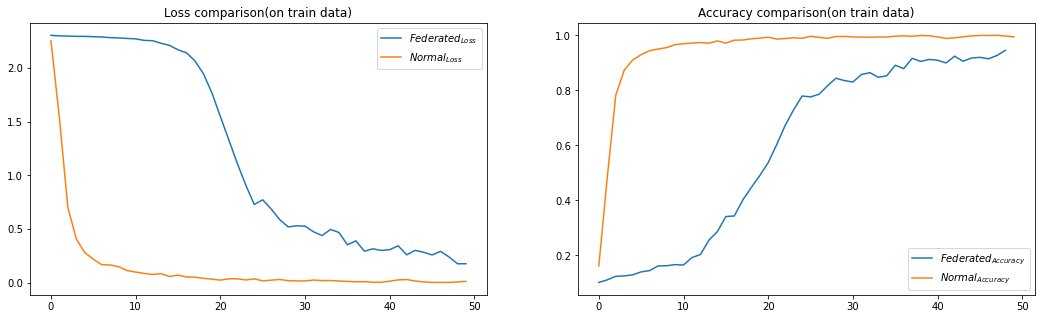

In [38]:
figure = plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
plt.plot(federated_loss_train,label=r'$Federated_{ Loss}$')
plt.plot(normal_loss,label=r'$Normal_{ Loss}$')
plt.legend()
plt.title("Loss comparison(on train data)")
plt.subplot(1,2,2)
plt.plot(federated_accuracy_train, label=r'$Federated_{ Accuracy}$')
plt.plot(normal_accuracy, label=r'$Normal_{ Accuracy}$')
plt.title("Accuracy comparison(on train data)")
print("Final Accuracy: fed=({:.4f})  VS normal=({:.4f})".format(federated_accuracy_test[-1],test_results_normal[1]))

l=plt.legend()

Final Accuracy: fed=(0.8814)  VS normal=(0.9627)


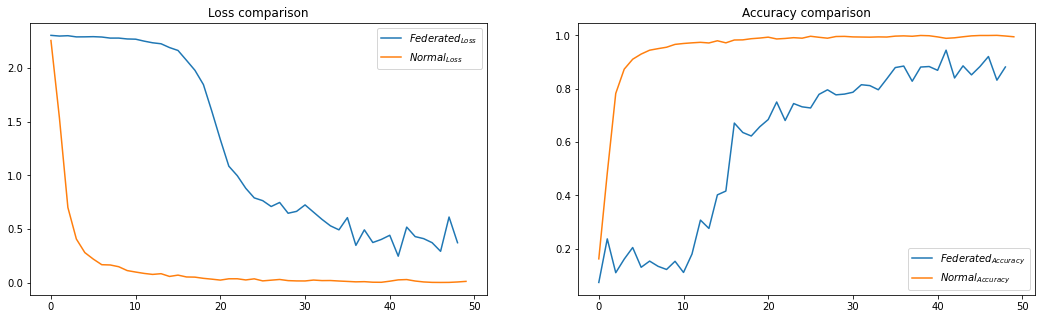

In [39]:
figure = plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
plt.plot(federated_loss_test,label=r'$Federated_{ Loss}$')
plt.plot(normal_loss,label=r'$Normal_{ Loss}$')
plt.legend()
plt.title("Loss comparison")
plt.subplot(1,2,2)
plt.plot(federated_accuracy_test, label=r'$Federated_{ Accuracy}$')
plt.plot(normal_accuracy, label=r'$Normal_{ Accuracy}$')
plt.title("Accuracy comparison")
print("Final Accuracy: fed=({:.4f})  VS normal=({:.4f})".format(federated_accuracy_test[-1],test_results_normal[1]))

l=plt.legend()

In [40]:
t2=time()
print(datetime.timedelta(seconds=int(t2-t1)))

0:12:02
